<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Factorization Machine Deep Dive

Factorization machine (FM) is one of the representative algorithms that are used for building content-based recommender model. The algorithm is powerful in terms of capturing the high-order interactions between input features. In addition, it provides better generalization capability and expressiveness compared to the other classic algorithms such as SVM. The most recent research extends the basic FM algorithms by using deep learning techniques, which achieve remarkable improvement in a few practical use cases.

This notebook presents a deep dive into the Factorization Machine algorithm, and demonstrates some best practices of using the contemporary FM implementations like [`xlearn`](https://github.com/aksnzhy/xlearn) for dealing with tasks like click-through rate prediction.

## 1 Factorization Machine

### 1.1 Factorization Machine

FM is an algorithm that uses factorization in prediction tasks with data set of high sparsity. The algorithm was original proposed in [here](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf). Traditionally, the algorithms such as SVM failed in dealing with highly sparse data that is usually seen in many contemporary problems, e.g., click-through rate prediction, recommendation, etc. FM handles the problem by modeling not just first-order linear components for predicting the label, but also the cross-product of the feature variables in order to capture more generalized correlation between variables and label. 

For example, usually, the data that appears in recommendation problems can be encoded in the following way - the user, item, and feature vectors are transformed into one-hot representation for building model. For this arrangement, using the classic algorithms like linear regression, SVM, for predicting the target, are that
1. The feature vectors are highly sparse, and thus it makes it hard to converge the parameters to fit the model efficienly
2. Cross-product of features will be sparse as well, and this in turn, reduces the expressiveness of a model if it is designed to capture the high-order interactions between features

<img src="https://recodatasets.blob.core.windows.net/images/fm_data.png?sanitize=true">

The FM algorithm is designed to tackle the above two problems by factorizing latent vectors that model the low- and high-order components. The general idea of a FM model is expressed in the following equation:

$$\hat{y}(\textbf{x})=w_{0}+\sum^{n}_{i=1}w_{i}x_{i}+\sum^{n}_{i=1}\sum^{n}_{j=i+1}<\textbf{v}_{i}, \textbf{v}_{j}>x_{i}x_{j}$$

where $\hat{y}$ and $\textbf{x}$ are the target to predict and input feature vectors, respectively. $w_{i}$ is the model parameters for the first-order component. $<\textbf{v}_{i}, \textbf{v}_{j}>$ is the dot product of two latent factors for the second-order interaction of feature variables, and it is defined as  

$$<\textbf{v}_{i}, \textbf{v}_{j}>=\sum^{k}_{f=1}v_{i,f}\cdot v_{j,f}$$

Compared to using fixed parameter for the high-order interaction components, using the factorized vectors increase generalization as well as expressiveness of the model. In addition to this, the computation complexity of the model is $O(kn)$ where $k$ and $n$ are the dimensionalities of the factorization vector and input feature vector, respectively.

### 1.2 Field-Aware Factorization Machine

Field-aware factorization machine (FFM) is an extension to FM. It was originally introduced in [here](https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf).

The advantage of FFM over FM is that, it uses different factorized latent factors for different groups of features. The "group" is called "field" in the context of FFM. Putting features into fields resolves the issue that the latent factors shared by features that intuitively represent different categories of information may not well generalize the correlation. 

Different from the formula for the high-order components as can be seen above in the FM equation, in the FFM settings, the equation changes to 

$$\theta_{\text{FFM}}(\textbf{w}\textbf{x})=\sum^{n}_{j1=1}\sum^{n}_{j2=j1+1}<\textbf{v}_{j1,f2}, \textbf{v}_{j2,f1}>x_{j1}x_{j2}$$

where $f_1$ and $f_2$ are the fields of $j_1$ and $j_2$, respectively.

Compared to FM, the computational complexity increases to $O(n^2k)$. However, since the latent factors in FFM only need to learn the effect within the field, so the $k$ values in FFM is usually much smaller than that in FM.

## 2 Factorization Machine Implementation

### 2.1 Implementations

The following table summarizes the implementations of FM/FFM. 

|Implementation|Language|Notes|
|-----------------|------------------|------------------|
|[libffm](https://github.com/ycjuan/libffm)|C++|Original implemenation of FFM algorithm. It is handy in model building, but does not support Python interface|
|[xlearn](https://github.com/aksnzhy/xlearn)|C++ with Python interface|More computationally efficient compared to libffm without loss of modeling effectiveness|
|[Vowpal Wabbit FM](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Matrix-factorization-example)|Online library with estimator API|Easy to use by calling API, but flexibility and configurability are limited|
|[microsoft/recommenders xDeepFM](https://github.com/microsoft/recommenders/blob/master/reco_utils/recommender/deeprec/models/xDeepFM.py)|Python|Support flexible interface with different configurations of FM and FM extensions, i.e., LR, FM, and/or CIN|

Other than `libffm`, all the other three can be used in a Python environment. A deep dive of using Vowbal Wabbit for FM model can be found [here](https://github.com/microsoft/recommenders/blob/master/notebooks/02_model/vowpal_wabbit_deep_dive.ipynb), and a quick start of Microsoft xDeepFM algorithm can be found [here](https://github.com/microsoft/recommenders/blob/master/notebooks/00_quick_start/xdeepfm_criteo.ipynb).

Therefore, in the example below, only code examples and best practices of using `xlearn` are presented.

### 2.2 xlearn

Setups for using `xlearn`.

1. `xlearn` is implemented in C++ and has Python bindings, so it can be directly installed as a Python package from PyPI. The installation of `xlearn` is enabled in the [Recommenders repo environment setup script](https://github.com/microsoft/recommenders/blob/master/scripts/generate_conda_file.py). One can follow the general setup steps to install the environment as required, in which `xlearn` is installed as well.
2. NOTE `xlearn` may require some base libraries installed as prerequisites in the system, e.g., `cmake`.

After a succesful creation of the environment, one can load the packages to run `xlearn` in a Jupyter notebook or Python script.

In [65]:
%matplotlib notebook

In [79]:
import time
import sys
sys.path.append("../../")
import os
import papermill as pm
from tempfile import TemporaryDirectory
import xlearn as xl
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from reco_utils.common.constants import SEED
from reco_utils.recommender.deeprec.deeprec_utils import (
    download_deeprec_resources, prepare_hparams
)
from reco_utils.recommender.deeprec.models.xDeepFM import XDeepFMModel
from reco_utils.recommender.deeprec.IO.iterator import FFMTextIterator
from reco_utils.tuning.parameter_sweep import generate_param_grid
from reco_utils.dataset.pandas_df_utils import LibffmConverter

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Tensorflow version: 1.12.0


In the FM model building, data is usually represented in the libsvm data format. That is, `label feat1:val1 feat2:val2 ...`, where `label` is the target to predict, and `val` is the value to each feature `feat`.

FFM algorithm requires data to be represented in the libffm format, where each vector is split into several fields with categorical/numerical features inside. That is, `label field1:feat1:val1 field2:feat2:val2 ...`.

In the Microsoft/Recommenders utility functions, [a libffm converter](https://github.com/microsoft/recommenders/blob/290dd920d4a6a4d3bff71dd9ee7273be0c02dbbc/reco_utils/dataset/pandas_df_utils.py#L86) is provided to achieve the transformation from a tabular feature vectors to the corresponding libffm representation. For example, the following shows how to transform the format of a synthesized data by using the module of `LibffmConverter`.

In [81]:
df_feature_original = pd.DataFrame({
    'rating': [1, 0, 0, 1, 1],
    'field1': ['xxx1', 'xxx2', 'xxx4', 'xxx4', 'xxx4'],
    'field2': [3, 4, 5, 6, 7],
    'field3': [1.0, 2.0, 3.0, 4.0, 5.0],
    'field4': ['1', '2', '3', '4', '5']
})

converter = LibffmConverter().fit(df_feature_original, col_rating='rating')
df_out = converter.transform(df_feature_original)
df_out

,rating,field1,field2,field3,field4
0,1,1:1:1,2:4:3,3:5:1.0,4:6:1
1,0,1:2:1,2:4:4,3:5:2.0,4:7:1
2,0,1:3:1,2:4:5,3:5:3.0,4:8:1
3,1,1:3:1,2:4:6,3:5:4.0,4:9:1
4,1,1:3:1,2:4:7,3:5:5.0,4:10:1


In [83]:
print('There are in total {0} fields and {1} features.'.format(converter.field_count, converter.feature_count))

There are in total 4 fields and 10 features.


To illustrate the use of `xlearn`, the following example uses the [Criteo data set](https://labs.criteo.com/category/dataset/), which has already been processed in the libffm format, for building and evaluating a FFM model built by using `xlearn`. Sometimes, it is important to know the total numbers of fields and features. When building a FFM model, `xlearn` can count these numbers automatically.

In [40]:
tmpdir = TemporaryDirectory()

data_path = tmpdir.name
yaml_file = os.path.join(data_path, r'xDeepFM.yaml')
train_file = os.path.join(data_path, r'cretio_tiny_train')
valid_file = os.path.join(data_path, r'cretio_tiny_valid')
test_file = os.path.join(data_path, r'cretio_tiny_test')
model_file = os.path.join(data_path, r'model.out')
output_file = os.path.join(data_path, r'output.txt')

if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.blob.core.windows.net/deeprec/', data_path, 'xdeepfmresources.zip')

100%|██████████| 10.3k/10.3k [00:04<00:00, 2.15kKB/s]


The following steps are from the [official documentation of `xlearn`](https://xlearn-doc.readthedocs.io/en/latest/index.html) for building a model. To begin with, we do not modify any training parameter values. 

NOTE, if `xlearn` is run through command line, the training process can be displayed in the console.

In [41]:
# Training task
ffm_model = xl.create_ffm()        # Use field-aware factorization machine (ffm)
ffm_model.setTrain(train_file)     # Set the path of training dataset
ffm_model.setValidate(valid_file)  # Set the path of validation dataset

# Parameters:
#  0. task: binary classification
#  1. learning rate: 0.2
#  2. regular lambda: 0.002
#  3. evaluation metric: accuracy
param = {'task':'binary', 'lr':0.2, 'lambda':0.002, 'metric':'auc'}

# Start to train
# The trained model will be stored in model.out

time_start = time.time()

ffm_model.fit(param, model_file)

time_train = time.time() - time_start

# Prediction task
ffm_model.setTest(test_file)  # Set the path of test dataset
ffm_model.setSigmoid()        # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
time_start = time.time()

ffm_model.predict(model_file, output_file)

time_predict = time.time() - time_start

The output are the predicted labels (i.e., 1 or 0) for the testing data set. AUC score is calculated to evaluate the model performance.

In [42]:
with open(output_file) as f:
    predictions = f.readlines()

with open(test_file) as f:
    truths = f.readlines()

truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])

auc_score = roc_auc_score(truths, predictions)

In [43]:
auc_score

0.7527209626518907

In [44]:
print('Training takes {0:.2f}s and predicting takes {1:.2f}s.'.format(time_train, time_predict))

Training takes 23.07s and predicting takes 1.21s.


It can be seen that the model building/scoring process is fast and the model performance is good. 

### 2.3 Hyperparameter tuning of `xlearn`

The following presents a naive approach to tune the parameters of `xlearn`, which is using grid-search of parameter values to find the optimal combinations. It is worth noting that the original [FFM paper](https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf) gave some hints in terms of the impact of parameters on the sampled Criteo dataset. 

The following are the parameters that can be tuned in the `xlearn` implementation of FM/FFM algorithm.

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`lr`|Learning rate|0.2|Higher learning rate helps fit a model more efficiently but may also result in overfitting.|
|`lambda`|Regularization parameter|0.00002|The value needs to be selected empirically to avoid overfitting.|
|`k`|Dimensionality of the latent factors|4|In FFM the effect of k is not that significant as the algorithm itself considers field where `k` can be small to capture the effect of features within each of the fields.|
|`init`|Model initialization|0.66|-|
|`epoch`|Number of epochs|10|Using a larger epoch size will help converge the model to its optimal point|

In [69]:
param_dict = {
    "lr": [0.0001, 0.001, 0.01],
    "lambda": [0.001, 0.01, 0.1]
}

param_grid = generate_param_grid(param_dict)

In [70]:
auc_scores = []

time_start = time.time()

for param in param_grid:
    ffm_model = xl.create_ffm()       
    ffm_model.setTrain(train_file)     
    ffm_model.setValidate(valid_file)
    ffm_model.fit(param, model_file)
    
    ffm_model.setTest(test_file)  
    ffm_model.setSigmoid()        
    ffm_model.predict(model_file, output_file)

    with open(output_file) as f:
        predictions = f.readlines()

    with open(test_file) as f:
        truths = f.readlines()

    truths = np.array([float(truth.split(' ')[0]) for truth in truths])
    predictions = np.array([float(prediction.strip('')) for prediction in predictions])
    
    auc_scores.append(roc_auc_score(truths, predictions))

time_tune = time.time() - time_start

auc_scores = [float('%.4f' % x) for x in auc_scores]
auc_scores_array = np.reshape(auc_scores, (len(param_dict["lr"]), len(param_dict["lambda"]))) 

auc_df = pd.DataFrame(
    data=auc_scores_array, 
    index=pd.Index(param_dict["lr"], name="LR"), 
    columns=pd.Index(param_dict["lambda"], name="Lambda")
)

In [73]:
print('Tuning by grid search takes {0:.2} min'.format(time_tune / 60))

Tuning by grid search takes 7.3 min


<IPython.core.display.Javascript object>


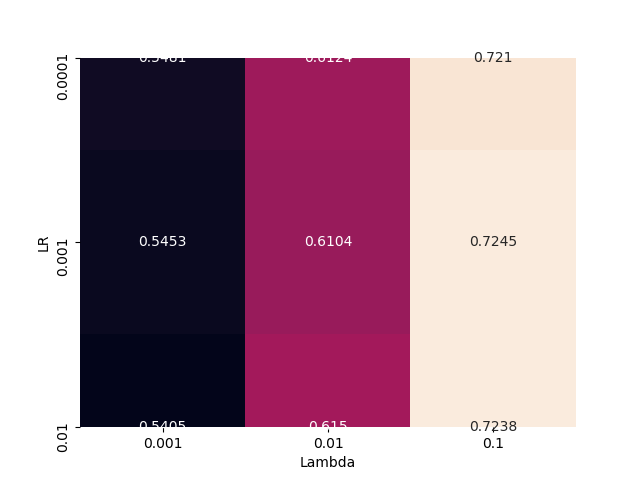

In [74]:
fig, ax = plt.subplots()
sns.heatmap(auc_df, cbar=False, annot=True, fmt=".4g")

More advanced tuning methods like Bayesian Optimization can be used for searching for the optimal model efficiently. The benefit of using, for example, `HyperDrive` from Azure Machine Learning Services, for tuning the parameters, is that, the tuning tasks can be distributed across nodes of a cluster and the optimization can be run concurrently to save the total cost.

* Details about how to tune hyper parameters by using Azure Machine Learning Services can be found [here](https://github.com/microsoft/recommenders/tree/master/notebooks/04_model_select_and_optimize).
* Note, to enable the tuning task on Azure Machine Learning Services by using HyperDrive, one needs a Docker image to containerize the environment where `xlearn` can be run. The Docker file provided [here](https://github.com/microsoft/recommenders/tree/master/docker) can be used for such purpose.

## References

1. Rendle, Steffen. "Factorization machines." 2010 IEEE International Conference on Data Mining. IEEE, 2010.
2. Juan, Yuchin, et al. "Field-aware factorization machines for CTR prediction." Proceedings of the 10th ACM Conference on Recommender Systems. ACM, 2016.
3. Lian, Jianxun, et al. "xdeepfm: Combining explicit and implicit feature interactions for recommender systems." Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018.
4. Langford, John, Lihong Li, and Alex Strehl. "Vowpal wabbit online learning project." (2007).